In [834]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.metrics import mean_squared_error

In [835]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [836]:
root = Path('./')

train_df = pd.read_csv(root/'train.csv')
test_df = pd.read_csv(root/'test.csv')
#weather_train_df = pd.read_feather(root/'weather_train.feather')
#weather_test_df = pd.read_feather(root/'weather_test.feather')
building_meta_df = pd.read_csv(root/'building_metadata.csv')

In [837]:
# i'm now using my leak data station kernel to shortcut.
leak_df = pd.read_feather('./leak.feather')

leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]

leak_df.head(5)

,building_id,meter,meter_reading,timestamp
1076662,0,0.0,173.370293,2017-01-01
1076663,1,0.0,53.512720,2017-01-01
1076664,2,0.0,6.143042,2017-01-01
1076665,3,0.0,101.701470,2017-01-01
1076666,4,0.0,1141.240666,2017-01-01


In [838]:
print (len(leak_df) / len(train_df))

0.5965531927523112


In [839]:
sample_submission1 = pd.read_csv('./submission_1219_1078.csv', index_col=0)
sample_submission2 = pd.read_csv('./KFold_lgb_108submission.csv', index_col=0)
sample_submission3 = pd.read_csv('./submission_cleanup108.csv', index_col=0)
sample_submission4 = pd.read_csv('./fe2_lgbm_107.csv', index_col=0)
sample_submission5 = pd.read_csv('./12_15_new108.csv', index_col=0)
sample_submission6 = pd.read_csv('./submission_1075.csv', index_col=0)

/home/lwlw/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [840]:
test_df['pred1'] = sample_submission1.meter_reading
test_df['pred2'] = sample_submission2.meter_reading
test_df['pred3'] = sample_submission3.meter_reading
test_df['pred4'] = sample_submission4.meter_reading
test_df['pred5'] = sample_submission5.meter_reading
test_df['pred6'] = sample_submission6.meter_reading

test_df.loc[test_df.pred1<0, 'pred1'] = 0 
test_df.loc[test_df.pred2<0, 'pred2'] = 0 
test_df.loc[test_df.pred3<0, 'pred3'] = 0 
test_df.loc[test_df.pred4<0, 'pred4'] = 0 
test_df.loc[test_df.pred5<0, 'pred5'] = 0 
test_df.loc[test_df.pred6<0, 'pred6'] = 0 

del  sample_submission1,  sample_submission2,  sample_submission3, sample_submission4, sample_submission5, sample_submission6
gc.collect()

test_df = reduce_mem_usage(test_df)
leak_df = reduce_mem_usage(leak_df)

Memory usage of dataframe is 3181.27 MB
Memory usage after optimization is: 1313.03 MB
Decreased by 58.7%
Memory usage of dataframe is 460.05 MB
Memory usage after optimization is: 299.03 MB
Decreased by 35.0%


In [841]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

In [842]:
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'pred1', 'pred2', 'pred3', 'pred4', 'pred5',  'pred6', 'row_id']], left_on = ['building_id', 'meter', 'timestamp'], right_on = ['building_id', 'meter', 'timestamp'], how = "left")
leak_df = leak_df.merge(building_meta_df[['building_id', 'site_id']], on='building_id', how='left')

In [843]:
leak_df.head(5)

,building_id,meter,meter_reading,timestamp,pred1,pred2,pred3,pred4,pred5,pred6,row_id,site_id
0,0,0.0,173.370300,2017-01-01,175.095001,186.168106,179.624802,165.920151,180.764999,176.689713,0,0
1,1,0.0,53.512718,2017-01-01,76.195000,85.102570,75.862000,79.619476,76.824997,72.337158,1,0
2,2,0.0,6.143042,2017-01-01,10.310000,13.020658,6.988500,7.377504,11.780000,7.210805,2,0
3,3,0.0,101.701469,2017-01-01,219.125000,249.669037,305.971710,301.158051,210.294998,281.318298,3,0
4,4,0.0,1141.240723,2017-01-01,983.400024,1130.942383,1408.412231,1342.144531,986.375000,1320.123535,4,0


In [844]:
leak_df['pred1_l1p'] = np.log1p(leak_df.pred1)
leak_df['pred2_l1p'] = np.log1p(leak_df.pred2)
leak_df['pred3_l1p'] = np.log1p(leak_df.pred3)
leak_df['pred4_l1p'] = np.log1p(leak_df.pred4)
leak_df['pred5_l1p'] = np.log1p(leak_df.pred5)
leak_df['pred6_l1p'] = np.log1p(leak_df.pred6)
leak_df['meter_reading_l1p'] = np.log1p(leak_df.meter_reading)

In [845]:
leak_df.head(5)

,building_id,meter,meter_reading,timestamp,pred1,pred2,pred3,pred4,pred5,pred6,row_id,site_id,pred1_l1p,pred2_l1p,pred3_l1p,pred4_l1p,pred5_l1p,pred6_l1p,meter_reading_l1p
0,0,0.0,173.370300,2017-01-01,175.095001,186.168106,179.624802,165.920151,180.764999,176.689713,0,0,5.171024,5.232007,5.196422,5.117516,5.202714,5.180039,5.161181
1,1,0.0,53.512718,2017-01-01,76.195000,85.102570,75.862000,79.619476,76.824997,72.337158,1,0,4.346334,4.455539,4.342011,4.389740,4.354463,4.295067,3.998434
2,2,0.0,6.143042,2017-01-01,10.310000,13.020658,6.988500,7.377504,11.780000,7.210805,2,0,2.425687,2.640532,2.078003,2.125550,2.547881,2.105451,1.966139
3,3,0.0,101.701469,2017-01-01,219.125000,249.669037,305.971710,301.158051,210.294998,281.318298,3,0,5.394196,5.524134,5.726756,5.710950,5.353255,5.643035,4.631826
4,4,0.0,1141.240723,2017-01-01,983.400024,1130.942383,1408.412231,1342.144531,986.375000,1320.123535,4,0,6.892032,7.031691,7.250928,7.202769,6.895050,7.186238,7.040747


In [846]:
leak_df[leak_df.pred1_l1p.isnull()]

,building_id,meter,meter_reading,timestamp,pred1,pred2,pred3,pred4,pred5,pred6,row_id,site_id,pred1_l1p,pred2_l1p,pred3_l1p,pred4_l1p,pred5_l1p,pred6_l1p,meter_reading_l1p


score1= 0.9862738


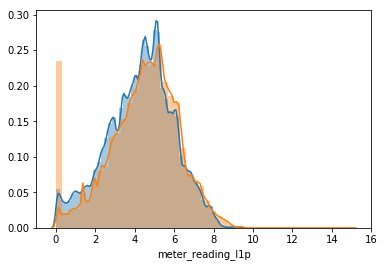

In [712]:
#ashrae-kfold-lightgbm-without-leak-1-08
sns.distplot(leak_df.pred1_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred1_l1p, leak_df.meter_reading_l1p))
print ('score1=', leak_score)

score2= 0.985471


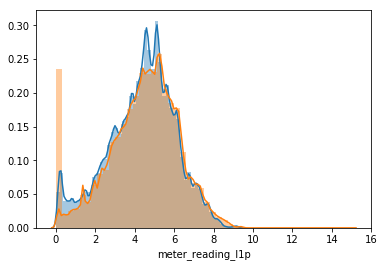

In [581]:
sns.distplot(leak_df.pred2_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred2_l1p, leak_df.meter_reading_l1p))
print ('score2=', leak_score)

score3= 0.9941885


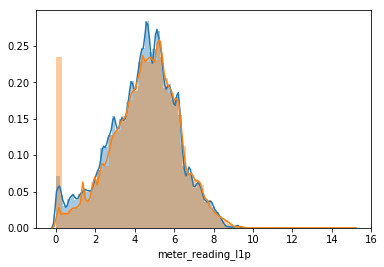

In [331]:
sns.distplot(leak_df.pred3_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred3_l1p, leak_df.meter_reading_l1p))
print ('score3=', leak_score)

score4= 0.9748973


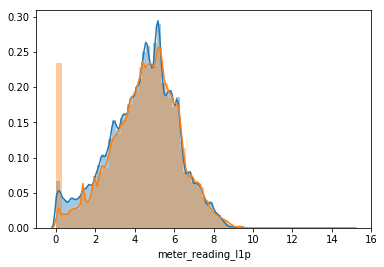

In [582]:
sns.distplot(leak_df.pred4_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred4_l1p, leak_df.meter_reading_l1p))
print ('score4=', leak_score)

score1= 0.98911035


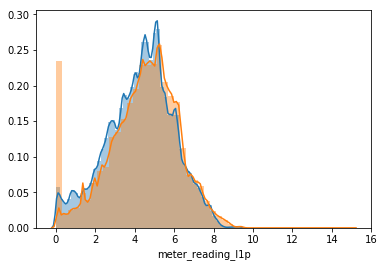

In [583]:
sns.distplot(leak_df.pred5_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred5_l1p, leak_df.meter_reading_l1p))
print ('score1=', leak_score)

score1= 0.9736784


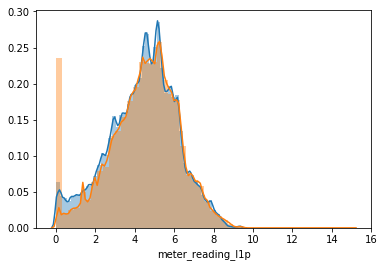

In [584]:
sns.distplot(leak_df.pred6_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred6_l1p, leak_df.meter_reading_l1p))
print ('score1=', leak_score)

In [847]:
v = 0.43 *  leak_df['pred4'].values + 0.18 * leak_df['pred1'].values  + 0.15 * leak_df['pred2'].values +  0.153 * leak_df['pred5'].values   #0.952
vl1p = np.log1p(v)
curr_score = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))

print ('score=', curr_score)

score= 0.9561314


In [848]:
sample_submission = pd.read_csv(os.path.join(root, 'sample_submission.csv'))

sample_submission['meter_reading'] = 0.43 * test_df.pred4 + 0.18 * test_df.pred1 + 0.15 * test_df.pred2 + 0.153 * test_df.pred5.values
sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

In [849]:
sample_submission.head()

,row_id,meter_reading
0,0,158.445024
1,1,72.471085
2,2,8.783565
3,3,238.565950
4,4,1074.690885


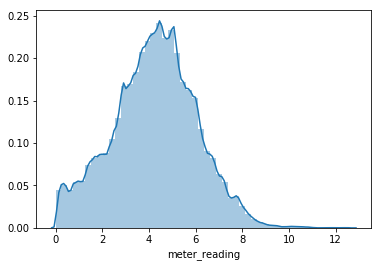

In [756]:
sns.distplot(np.log1p(sample_submission.meter_reading))

In [850]:
leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
sample_submission.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']

In [851]:
sample_submission.head(5)

,row_id,meter_reading
0,0,173.370300
1,1,53.512718
2,2,6.143042
3,3,101.701469
4,4,1141.240723


In [852]:
sample_submission.to_csv('submission_1219_02.csv', index=False, float_format='%.6f')